In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# download category_encoders

!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 871.3 kB/s eta 0:00:00


In [3]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('Set3')

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

import scipy.stats

plt.rcParams["font.family"] = "NanumBarunGothic"

from category_encoders.target_encoder import TargetEncoder

In [4]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,499 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and dire

In [5]:
plt.rc('font', family='NanumBarunGothic')

In [6]:
# data load

path = '/content/drive/MyDrive/dacon/2023.11.15/dataset'
orig = pd.read_csv(path + '/train.csv')
train = pd.read_csv(path + '/train.csv')
t = pd.read_csv(path + '/test.csv')

### 데이터 파악

In [7]:
# information

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [8]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   사고일시    10963 non-null  object
 2   요일      10963 non-null  object
 3   기상상태    10963 non-null  object
 4   시군구     10963 non-null  object
 5   도로형태    10963 non-null  object
 6   노면상태    10963 non-null  object
 7   사고유형    10963 non-null  object
dtypes: object(8)
memory usage: 685.3+ KB


In [9]:
# 유효성 검사 함수 정의

def making_val_table(df):
    '''입력받은 데이터셋의 유효성 검증을 위한 요약 테이블'''
    # dtypes
    df_dtypes = df.dtypes

    # nunique
    df_nunique = df.nunique()

    # null_values
    df_nan = df.isna().sum()

    val_table = pd.concat([df_dtypes, df_nunique, df_nan], axis=1)
    val_table.columns = ['dtype', 'nunique', 'nan']

    return val_table.reset_index()

In [10]:
table_train = making_val_table(train)
table_test = making_val_table(t)

table = pd.merge(left = table_train , right = table_test , on = 'index' ,
                 how = 'left').set_index('index')

In [11]:
# train을 test와 연동

target = train['ECLO']
train = train[t.columns]

### 간단한 EDA

#### 분석 전 전처리

In [12]:
# 분석 전 전처리

# datetime 데이터로 바꾸기
train['사고일시'] = pd.to_datetime(train['사고일시'])
t['사고일시'] = pd.to_datetime(t['사고일시'])

In [13]:
# 시군구 분리
# 시 , 군 , 구로 바꾼다
# 시의 경우 대구광역시밖에 없기에 삭제

gun = []
for i in range(len(train)):
    gun.append(train['시군구'].iloc[i].split()[1])

gu = []
for i in range(len(train)):
    gu.append(train['시군구'].iloc[i].split()[2])

train['군'] = gun
train['구'] = gu

gun = []
for i in range(len(t)):
    gun.append(t['시군구'].iloc[i].split()[1])

gu = []
for i in range(len(t)):
    gu.append(t['시군구'].iloc[i].split()[2])

t['군'] = gun
t['구'] = gu

#### 간단한 데이터 분석

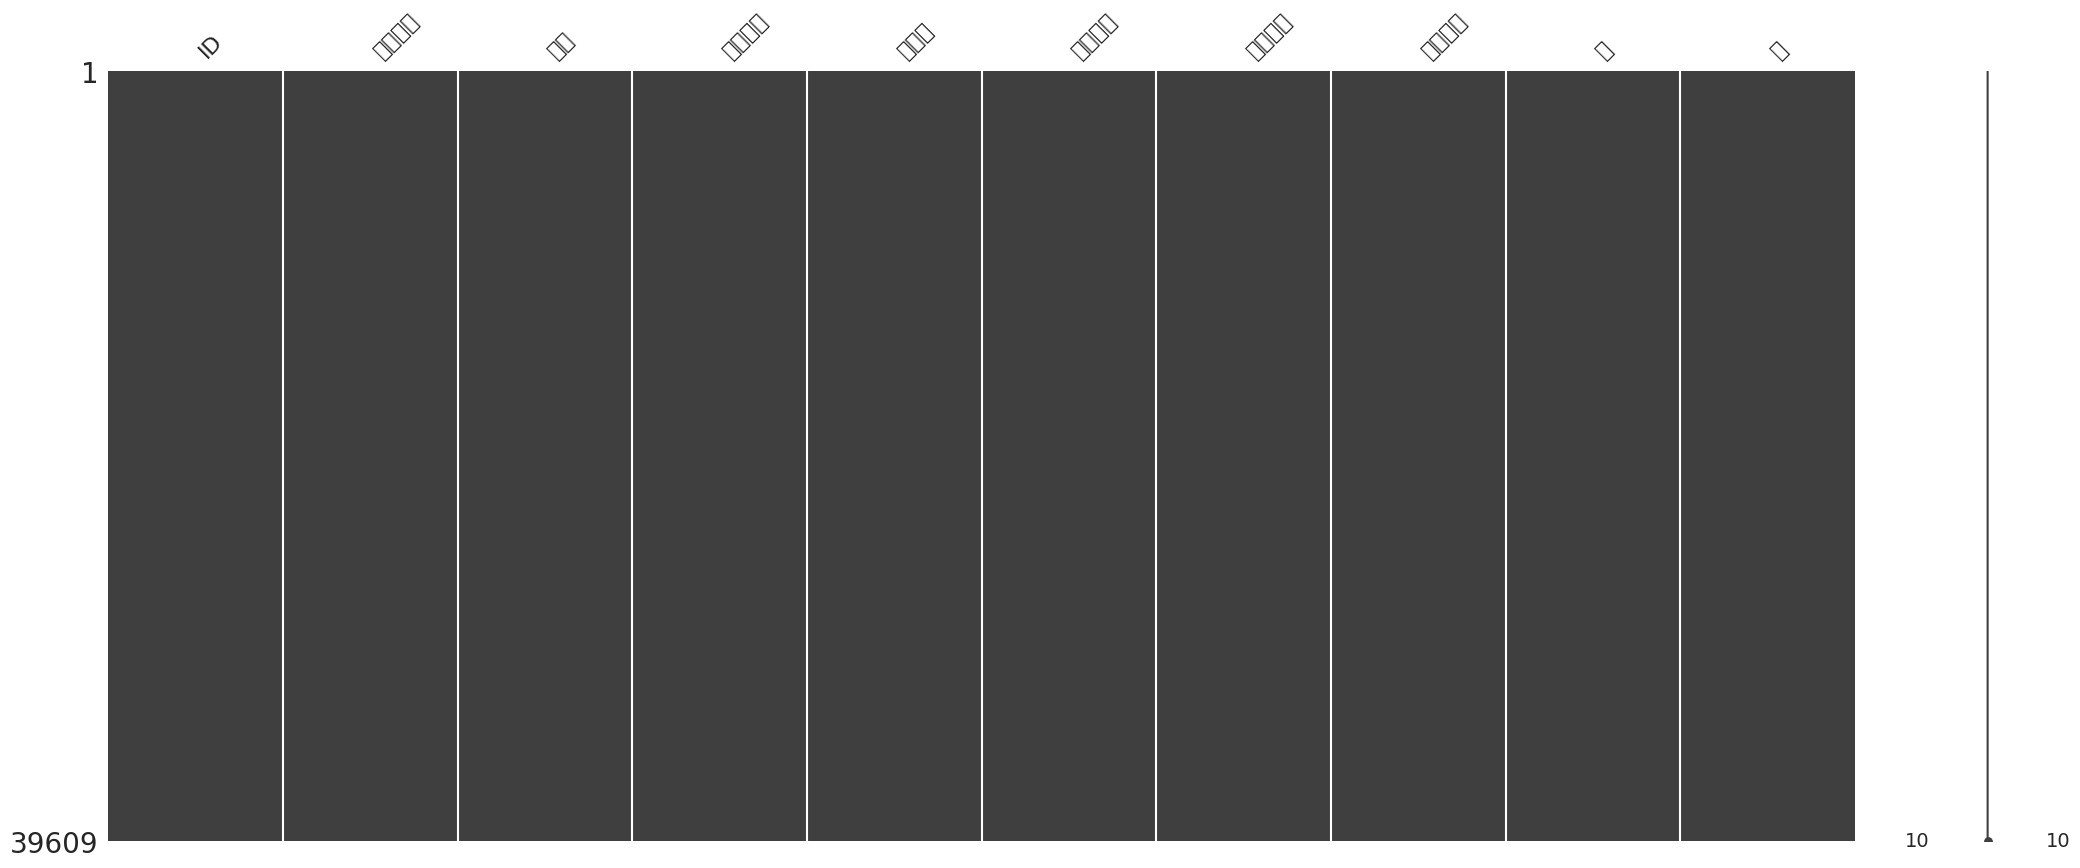

In [14]:
# 결측값

msno.matrix(train)

plt.savefig('NA.png')

<Axes: >

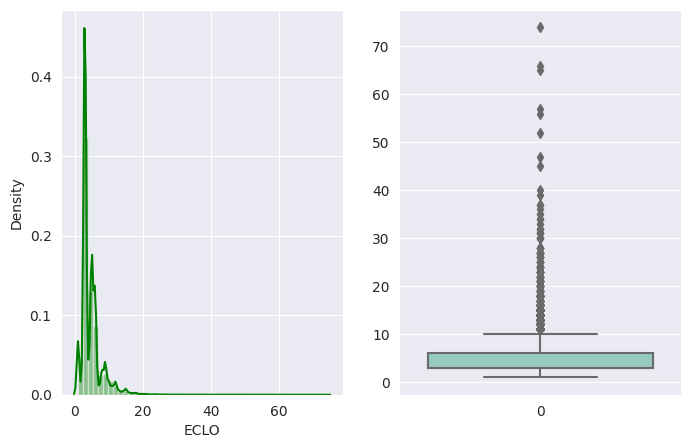

In [15]:
# target data distribution

fig , ax = plt.subplots(1 , 2 , figsize = (8 , 5))

sns.distplot(
    target ,
    color = 'g' ,
    ax = ax[0]
)

sns.boxplot(
    target ,
    ax = ax[1]
)

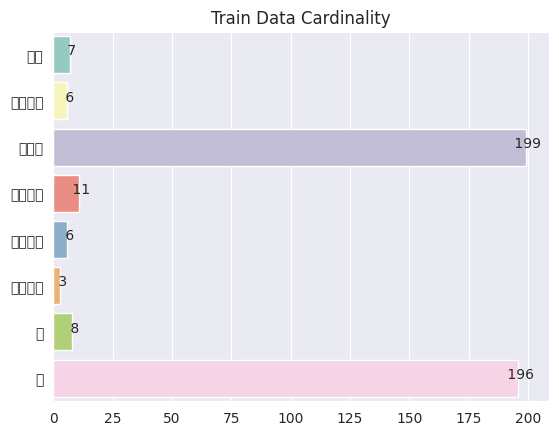

In [16]:
# 카디널리티

g = sns.barplot(
    y = train.nunique()[2:].index ,
    x = train.nunique()[2:].values
)

# 숫자 표시
for p in g.patches:
    g.text(
        p.get_x() + p.get_width() ,
        p.get_y() + (p.get_height() / 2) ,
        f"{p.get_width() : .0f}" ,
        ha = 'center'
    )

g.set_title('Train Data Cardinality')
plt.show()

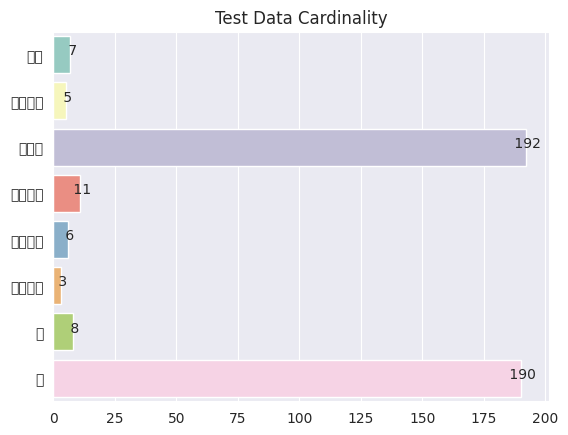

In [17]:
g = sns.barplot(
    y = t.nunique()[2:].index ,
    x = t.nunique()[2:].values
)

for p in g.patches:
    g.text(
        p.get_x() + p.get_width() ,
        p.get_y() + (p.get_height() / 2) ,
        f"{p.get_width() : .0f}" ,
        ha = 'center'
    )

g.set_title('Test Data Cardinality')
plt.show()

In [18]:
# 요일 , 기상상태 , 도로형태 , 노면상태 , 사고유형 , 군 , 구 분석

# 어떤 종류가 많은지 , ECLO와 어떤 연관이 있는지

# 함수 정의

def graph(df , col , condi = False):
    data = pd.concat([df[col] , target] , axis = 1)

    fig , ax = plt.subplots(1 , 2 , figsize = (13 , 5))

    # 빈도수
    sns.countplot(
        x = data[col] ,
        ax = ax[0]
    )

    if condi:
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45)

    # ECLO의 평균

    g_data = data.groupby([col])['ECLO'].mean()
    sns.barplot(
        x = g_data.index ,
        y = g_data.values ,
        ax = ax[1]
    )

    if condi:
        ax[1].set_xticklabels(ax[1].get_xticklabels() , rotation = 45)

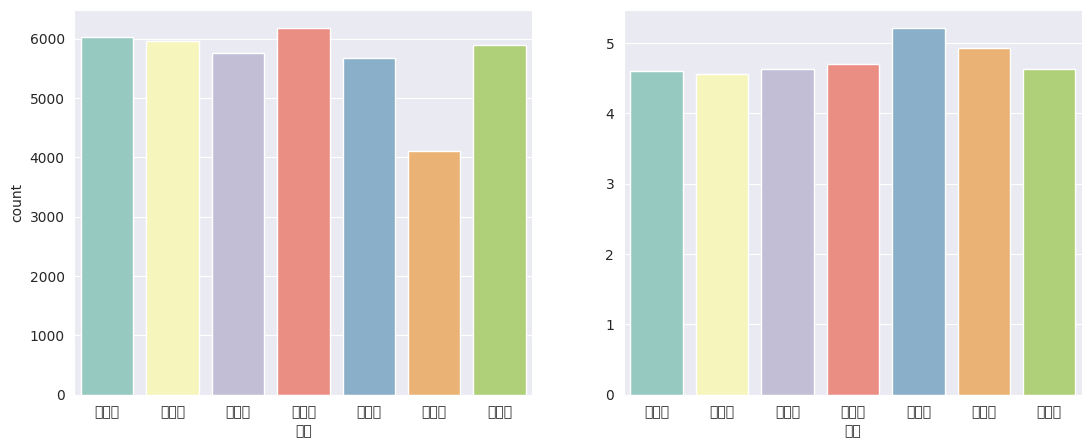

In [19]:
# 요일

graph(train , '요일')


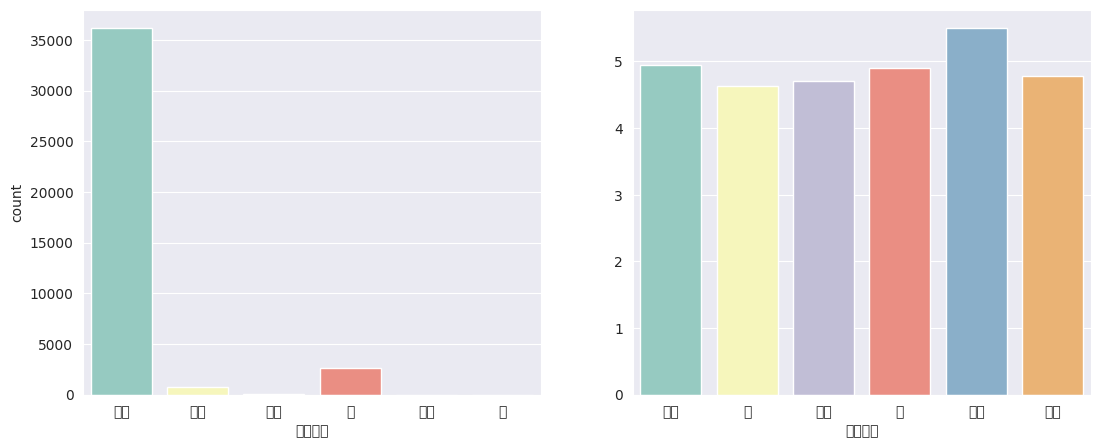

In [20]:
 # 기상상태

graph(train , '기상상태')

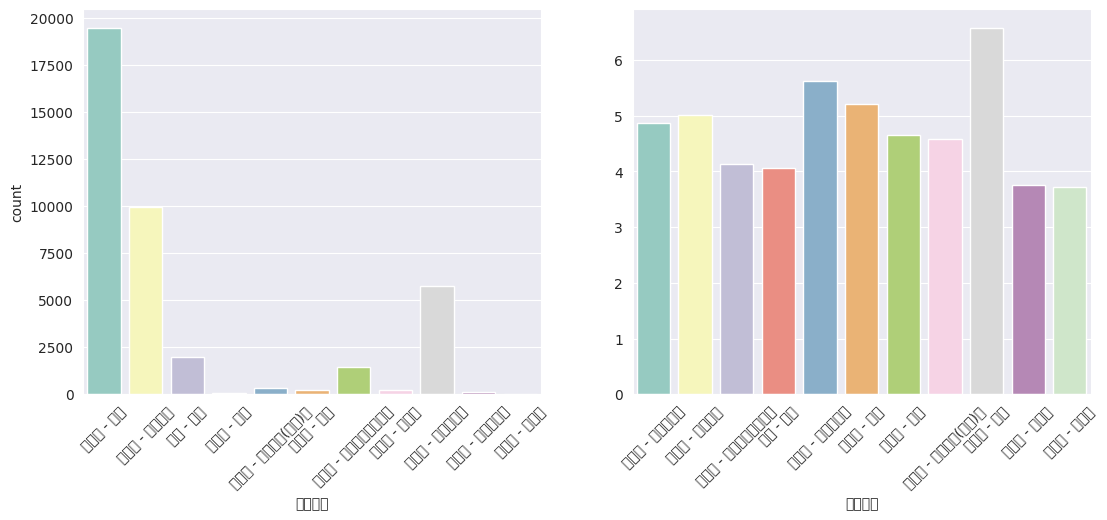

In [21]:
# 도로형태

graph(train , '도로형태' , True)

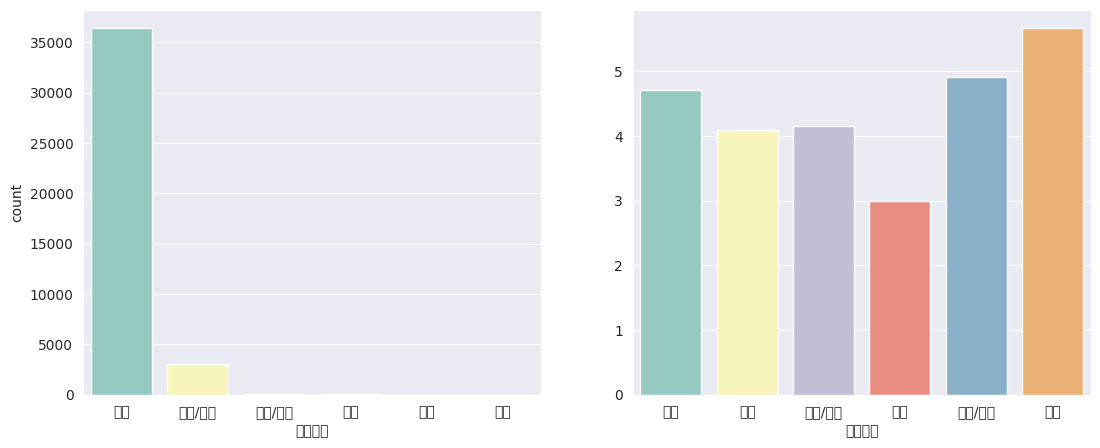

In [22]:
# 노면상태

graph(train , '노면상태')

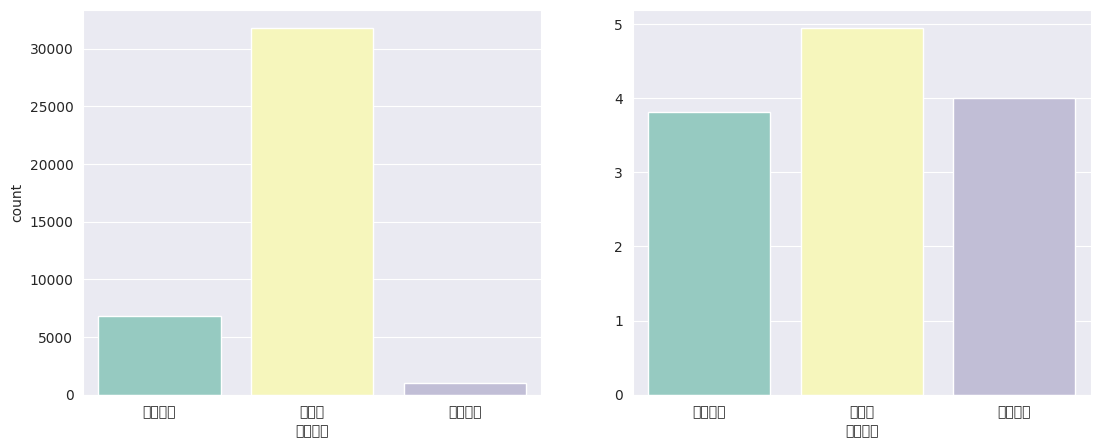

In [23]:
# 사고유형

graph(train , '사고유형')

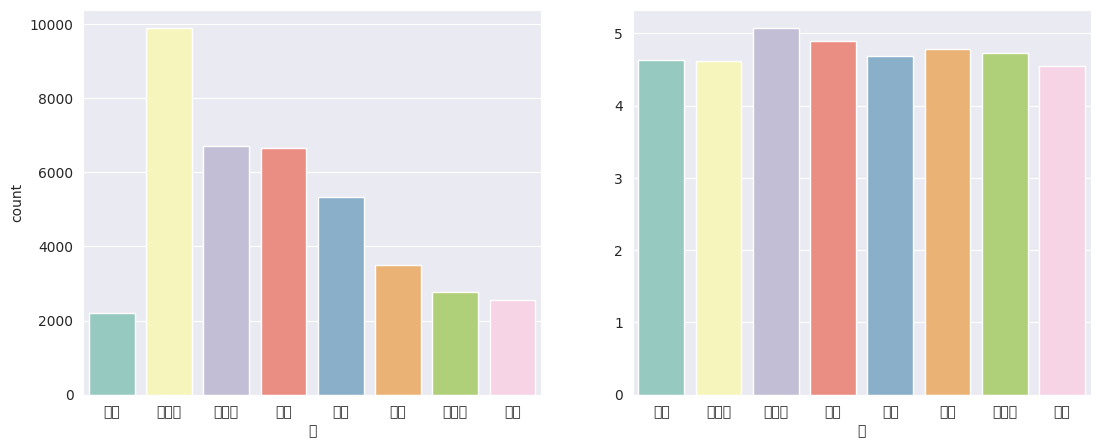

In [24]:
# 군

graph(train , '군')

In [25]:
# 상관분석

from scipy.stats import chi2_contingency

data = train.drop(['ID' , '사고일시' , '구'] , axis = 1)

# 크래머V 계수

def cramers_V(var1 , var2):
    crosstab = np.array(pd.crosstab(var1 , var2 , rownames = None , colnames = None))
    stat = chi2_contingency(crosstab)[0]
    p_value = chi2_contingency(crosstab)[1]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1

    return np.sqrt(stat / (obs * mini)) , p_value

rows = []
p_rows = []
for var1 in data:
    cols = []
    p_cols = []
    for var2 in data:
        cramers , p_val = cramers_V(data[var1] , data[var2])
        cols.append(round(cramers , 2))
        p_cols.append(p_val)
    rows.append(cols)
    p_rows.append(p_cols)

cramers_result = np.array(rows)
cramer_df = pd.DataFrame(cramers_result , columns = data.columns , index = data.columns)

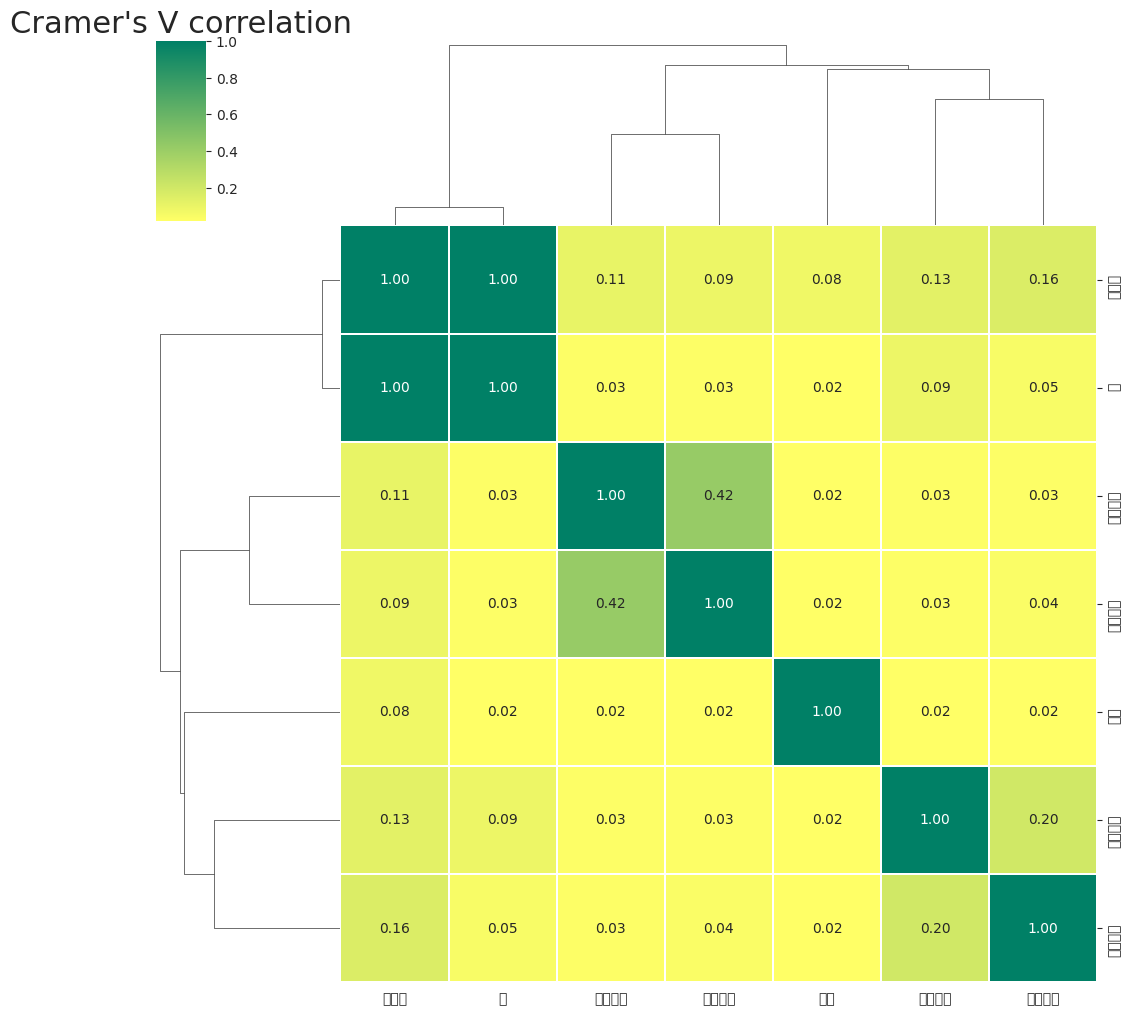

In [26]:
sns.clustermap(
    cramer_df ,
    annot = True ,
    fmt = '.2f' ,
    cmap = 'summer_r' ,
    linewidth = 0.1
)

plt.title("Cramer's V correlation" , fontsize = 22)

plt.savefig("Cramer's V correlation.png")

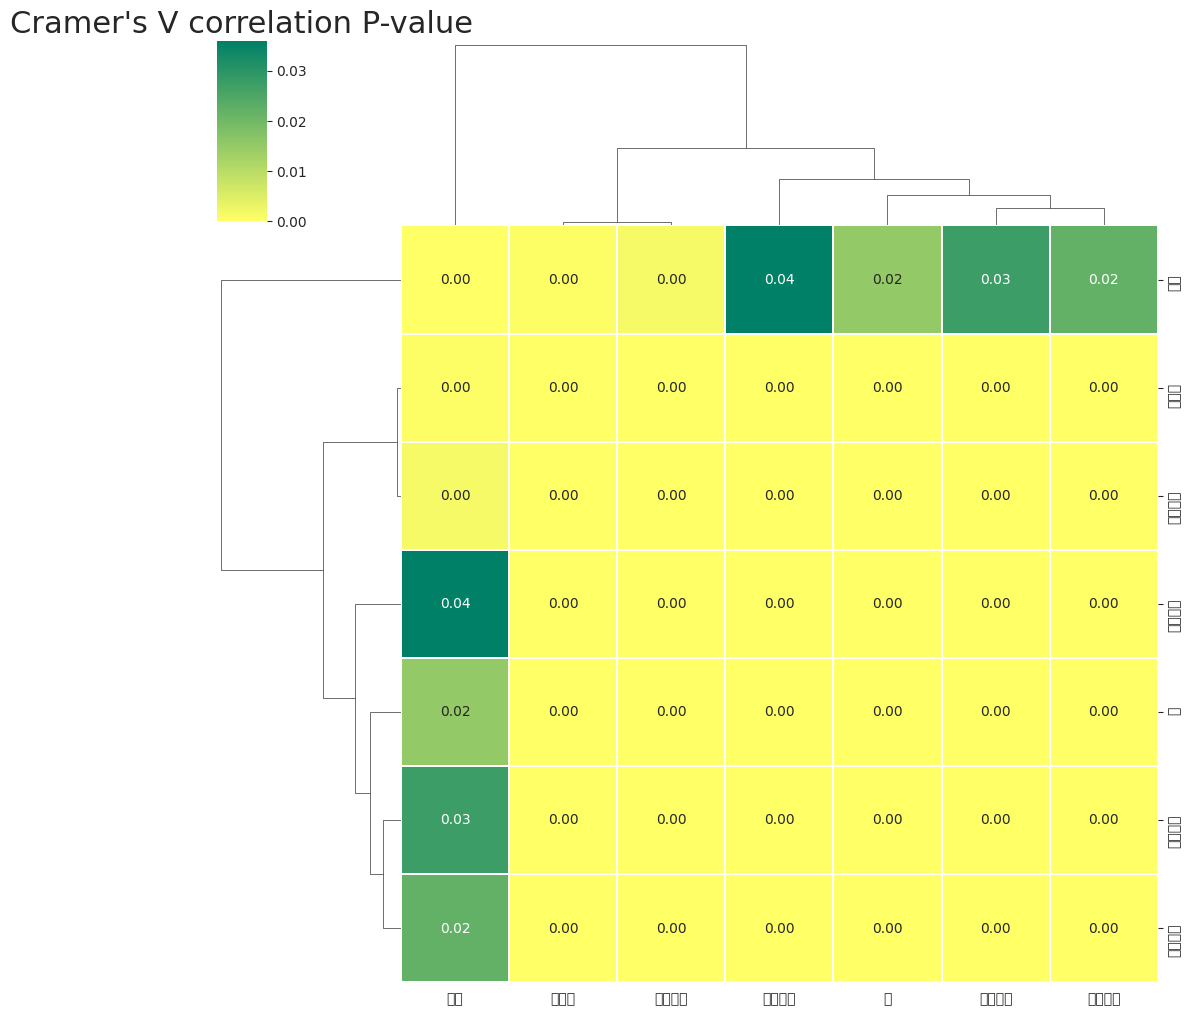

In [27]:
sns.clustermap(
    pd.DataFrame(p_rows , index = data.columns ,
                 columns = data.columns),
    annot = True ,
    fmt = '.2f' ,
    cmap = 'summer_r' ,
    linewidth = 0.1
)

plt.title("Cramer's V correlation P-value" , fontsize = 22)

plt.savefig("Cramer's V correlation P-value.png")

In [28]:
# 카이제곱 독립성 검정

p_vals = []
for var in train.columns[2:8]:
    cross = np.array(pd.crosstab(train[var] , target))
    _ , p_value , _ , _ = chi2_contingency(cross)
    p_vals.append(p_value)

In [29]:
p_vals = pd.Series(
    p_vals ,
    index = train.columns[2:8]
)

index = p_vals.index

for i in range(len(p_vals)):
    if p_vals[i] < 0.05:
        print(f"{index[i]} : 관련이 있다.")
    else:
        print(f"{index[i]} : 독립이다.")

요일 : 관련이 있다.
기상상태 : 독립이다.
시군구 : 관련이 있다.
도로형태 : 관련이 있다.
노면상태 : 독립이다.
사고유형 : 관련이 있다.


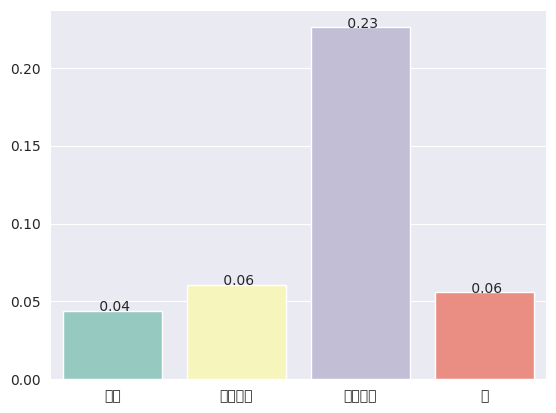

In [30]:
"""
종속변수와의 상관이 있는 데이터들
-> 요일 , 도로형태 , 사고유형 , 군
해당 변수들과 종속변수와의 상관관계의 강함을 측정
"""

cols = ['요일' , '도로형태' , '사고유형' , '군']
cramers = []
p_s = []

for var in cols:
    cramer , p = cramers_V(train[var] , target)
    cramers.append(cramer)
    p_s.append(p)

g = sns.barplot(
    x = cols ,
    y = cramers
)

for p in g.patches:
    g.text(
        p.get_x() + (p.get_width() / 2) ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : 0.2f}" ,
        ha = 'center'
    )

In [31]:
# 각 p_value

for i in range(len(p_s)):
    print(f"{cols[i]} p_value : {p_s[i]}")

요일 p_value : 2.7889563820901824e-12
도로형태 p_value : 2.4977920985114386e-105
사고유형 p_value : 0.0
군 p_value : 6.435352211350667e-53


#### 추가 분석

##### 요일

In [32]:
# 토 , 일에 따라 ECLO는 왜 올라가는가

train = pd.concat([train , target] , axis = 1)

In [33]:
# 주말과 주중에는 통계적으로 의미있는 차이가 있는가

data_weekday = train[(train['요일'] != '토요일') & (train['요일'] != '일요일')]['ECLO']
data_weekend = train[(train['요일'] == '토요일') | (train['요일'] == '일요일')]['ECLO']

def test(var1 , var2):
    _ , p_value_var , = scipy.stats.levene(var1 , var2)

    if p_value_var > 0.05:
        _ , p_value = scipy.stats.ttest_ind(var1 , var2 , equal_var = True)
    else:
        _ , p_value = scipy.stats.ttest_ind(var1 , var2 , equal_var = False)

    if p_value < 0.05:
        print("주중과 주말의 종속변수의 평균 차이는 통계적으로 의미있다.")
    else:
        print("아니다")

test(data_weekday , data_weekend)

주중과 주말의 종속변수의 평균 차이는 통계적으로 의미있다.


In [34]:
test(train[train['요일'] == '수요일']['ECLO'] , train[train['요일'] == '목요일']['ECLO'])

아니다


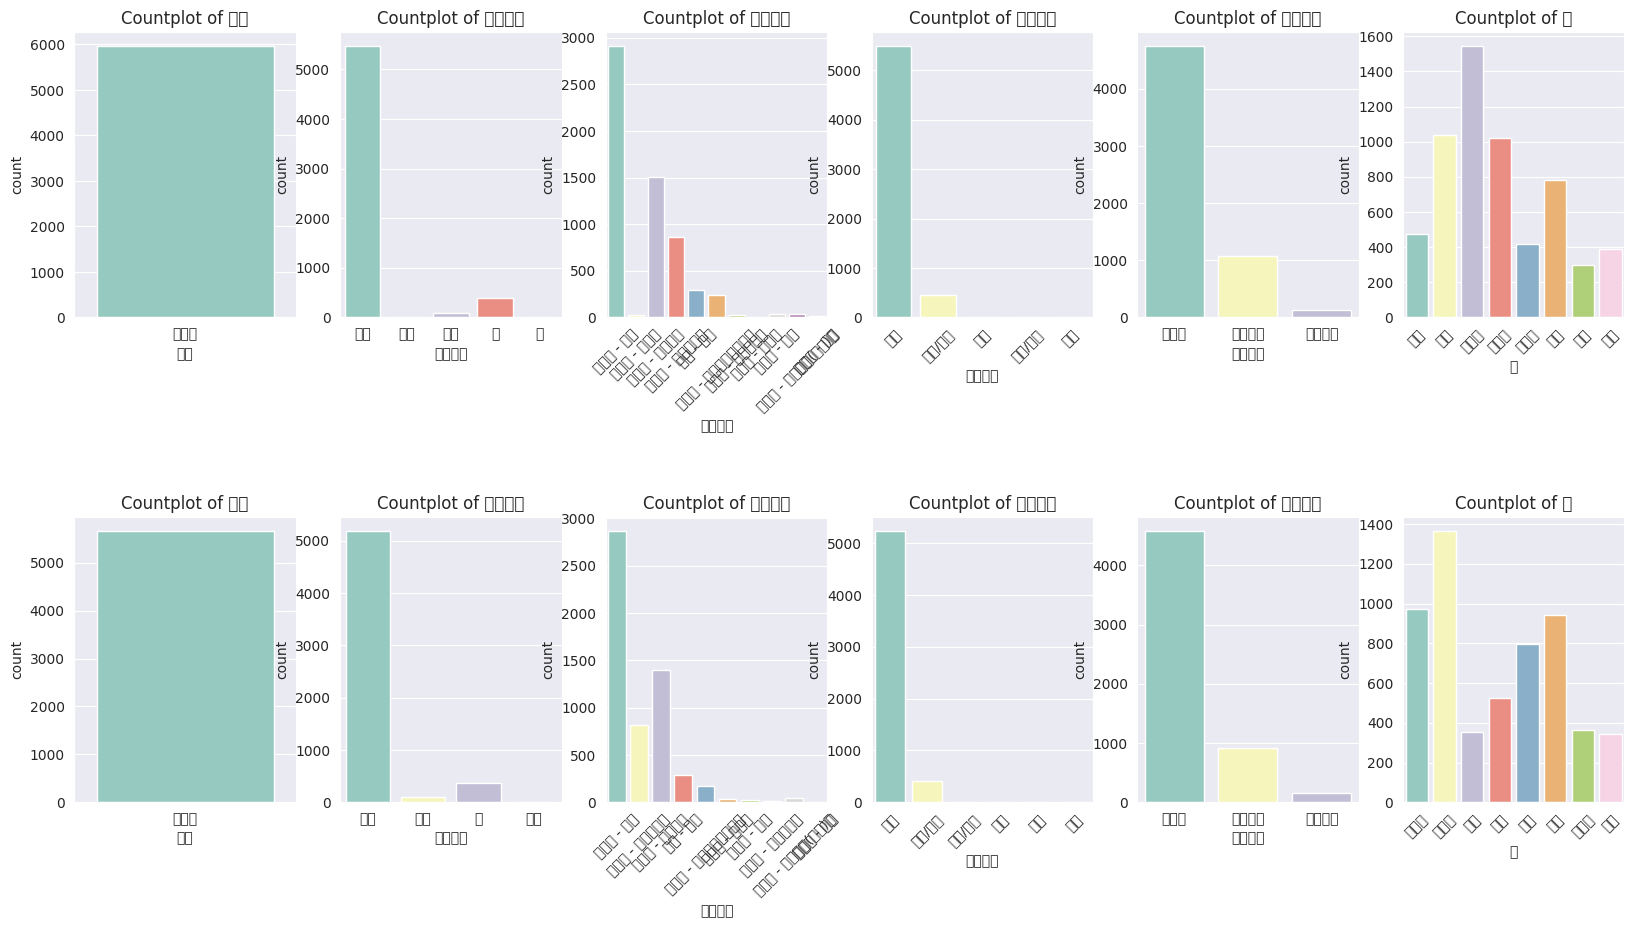

In [35]:
# 수요일 <-> 토요일 차이는 무엇이 있나

data1 = train[train['요일'] == '수요일']
data2 = train[train['요일'] == '토요일']

fig , ax = plt.subplots(2 , 6 , figsize = (20 , 10))
plt.subplots_adjust(hspace = 0.7)

cols = ['요일' , '기상상태' , '도로형태' , '노면상태' , '사고유형' , '군']

# data1 시각화 (수요일)
for i , col in enumerate(cols):

    if col == '도로형태' or col == '노면상태' or col == '군':
        sns.countplot(data = data1 , x = col , ax = ax[0][i]) ,
        ax[0][i].set_title(f"Countplot of {col}")
        ax[0][i].set_xticklabels(ax[0][i].get_xticklabels() , rotation = 45)
    else:
        sns.countplot(data = data1 , x = col , ax = ax[0][i]) ,
        ax[0][i].set_title(f"Countplot of {col}")

# data2 시각화 (토요일)
for i , col in enumerate(cols):

    if col == '도로형태' or col == '노면상태' or col == '군':
        sns.countplot(data = data2 , x = col , ax = ax[1][i]) ,
        ax[1][i].set_title(f"Countplot of {col}")
        ax[1][i].set_xticklabels(ax[1][i].get_xticklabels() , rotation = 45)
    else:
        sns.countplot(data = data2 , x = col , ax = ax[1][i]) ,
        ax[1][i].set_title(f"Countplot of {col}")

##### 도로형태

In [36]:
def test(var1 , var2):
    _ , p_value_var , = scipy.stats.levene(var1 , var2)

    if p_value_var > 0.05:
        _ , p_value = scipy.stats.ttest_ind(var1 , var2 , equal_var = True)
    else:
        _ , p_value = scipy.stats.ttest_ind(var1 , var2 , equal_var = False)

    if p_value < 0.05:
        print("단일로와 교차로의 종속변수의 평균 차이는 통계적으로 의미있다.")
    else:
        print("아니다")

In [37]:
data1 = train[train['도로형태'].str.split().str[0] == '단일로']['ECLO']
data2 = train[train['도로형태'].str.split().str[0] == '교차로']['ECLO']

In [38]:
test(data1 , data2)

단일로와 교차로의 종속변수의 평균 차이는 통계적으로 의미있다.


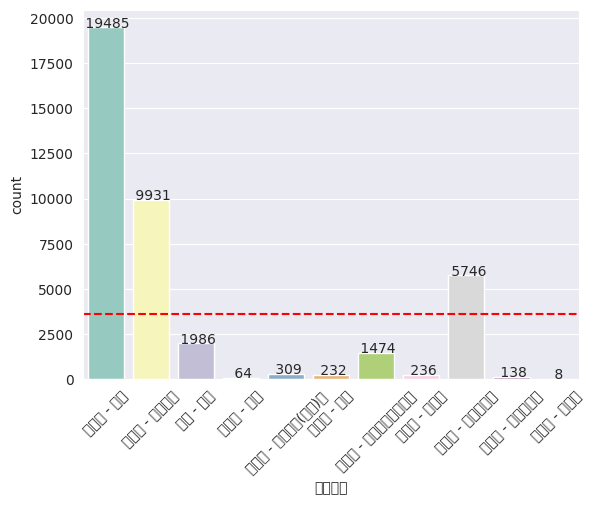

In [39]:
g = sns.countplot(
    x = train['도로형태']
)

g.axhline(train['도로형태'].value_counts().mean() , color = 'r' , linestyle = '--')

g.set_xticklabels(g.get_xticklabels() , rotation = 45)

for p in g.patches:
    g.text(
        p.get_x() + p.get_width() / 2 ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : 0.0f}" ,
        ha = 'center'
    )

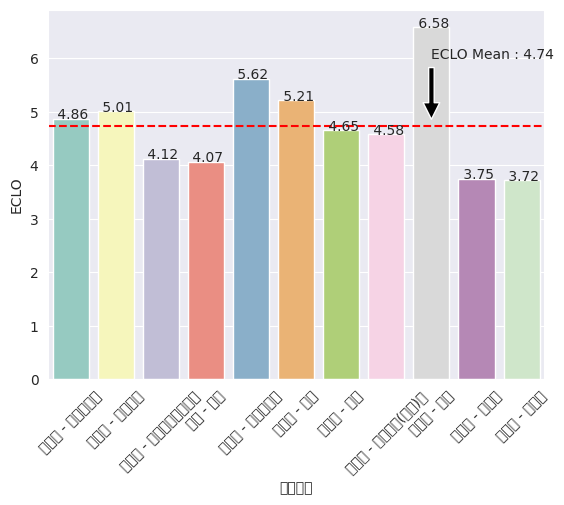

In [40]:
# 도로형태 분석

data = train.groupby(['도로형태']).agg({'ECLO' : 'mean'})

g = sns.barplot(
    data = data ,
    x = data.index ,
    y = 'ECLO'
)

# 수평선 넣기
g.axhline(data['ECLO'].mean() , color = 'r' , linestyle = '--')
# 화살표 넣기
g.annotate(f"ECLO Mean : {round(data['ECLO'].mean() , 2)}" , xy = (8 , 4.8) , xytext = (8 , 6) ,
           arrowprops = dict(facecolor = 'black' , shrink = 0.05))

# x label 돌리기
g.set_xticklabels(g.get_xticklabels() , rotation = 45)

for p in g.patches:
    g.text(
        p.get_x() + p.get_width() / 2 ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : 0.2f}" ,
        ha = 'center'
    )

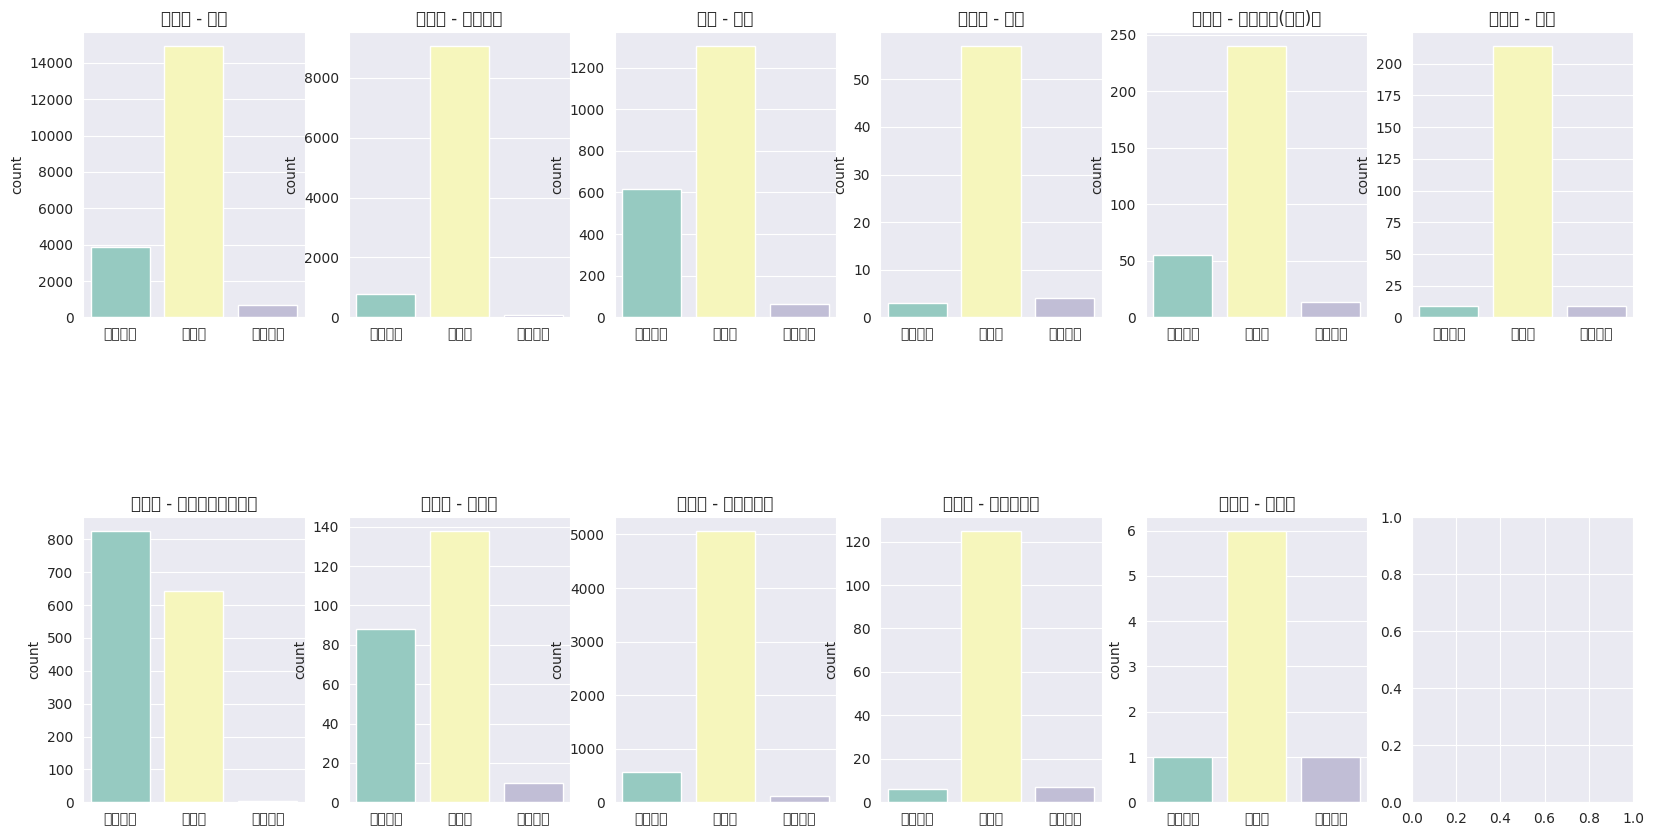

In [41]:
fig , ax = plt.subplots(2 , 6 , figsize = (20 , 10))
plt.subplots_adjust(hspace = 0.7)

for i in range(11):
    row = i // 6
    col = i % 6

    group = train[train['도로형태'] == train['도로형태'].unique()[i]]['사고유형']

    sns.countplot(
        x = group.values ,
        order = train['사고유형'].unique() ,
        ax = ax[row][col]
    )
    ax[row][col].set_title(f"{train['도로형태'].unique()[i]}")

##### 군

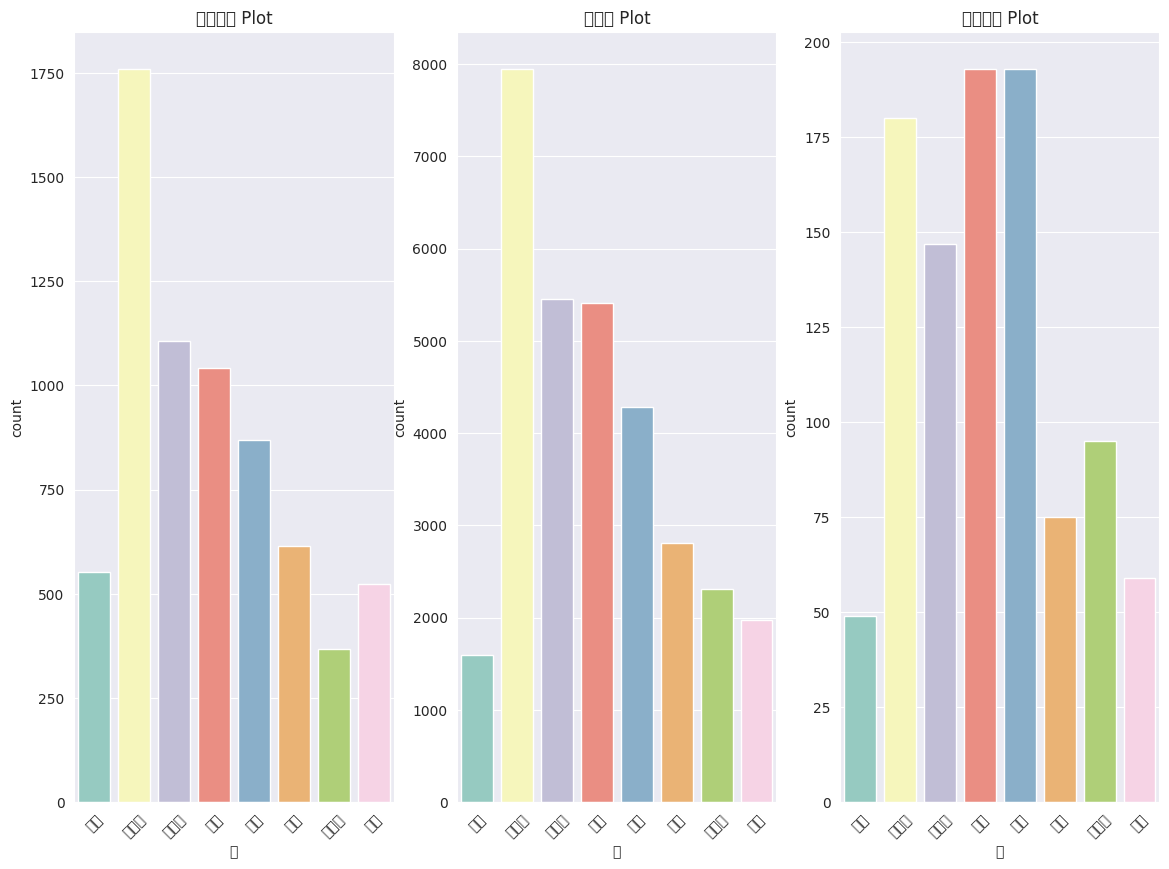

In [42]:
# 군에 따른 도로형태 비율

fig , ax = plt.subplots(1 , 3 , figsize = (14 , 10))

for i in range(3):

    sns.countplot(
        x = train[train['사고유형'] == train['사고유형'].unique()[i]]['군'] ,
        order = train['군'].unique() ,
        ax = ax[i]
    )
    ax[i].set_title(f"{train['사고유형'].unique()[i]} Plot")

    ax[i].set_xticklabels(ax[i].get_xticklabels() , rotation = 45)

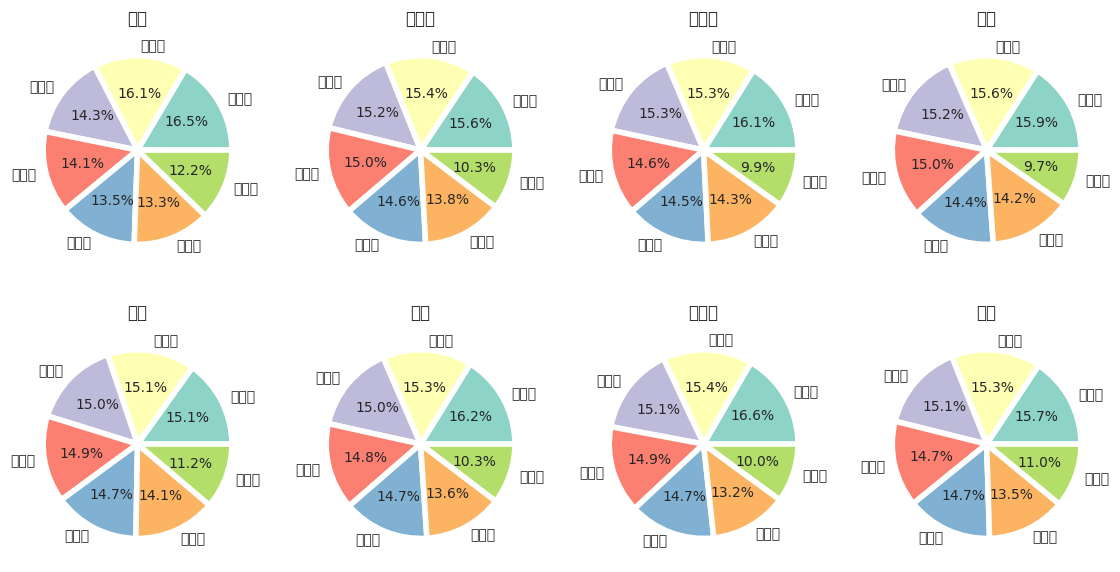

In [43]:
# 금 , 토 , 일의 포함 정도

fig , ax = plt.subplots(2 , 4 , figsize = (14 , 7))

for i in range(8):
    row = i // 4
    col = i % 4

    data = train[train['군'] == train['군'].unique()[i]]

    ax[row][col].pie(data['요일'].value_counts() / len(data) , labels = data['요일'].value_counts().index ,
            autopct = '%1.1f%%' , wedgeprops = {"linewidth" : 4})

    ax[row][col].set_title(f"{train['군'].unique()[i]}")

##### Outlier 분석

In [44]:
# 반드시 잘 된다!

# tukey 방식으로 outlier 색출

q1 = np.percentile(train['ECLO'] , 25)
q3 = np.percentile(train['ECLO'] , 75)

IQR = q3 - q1

upper_fence = q3 + 1.5 * IQR
lower_fence = q1 - 1.5 * IQR

outlier_data = train[(train['ECLO'] < lower_fence) | (train['ECLO'] > upper_fence)]

In [45]:
# 비율은 어느정도 인가?

print(f"이상치 데이터의 비율 : {round(len(outlier_data) / len(train) * 100 , 2)}%")

이상치 데이터의 비율 : 5.36%


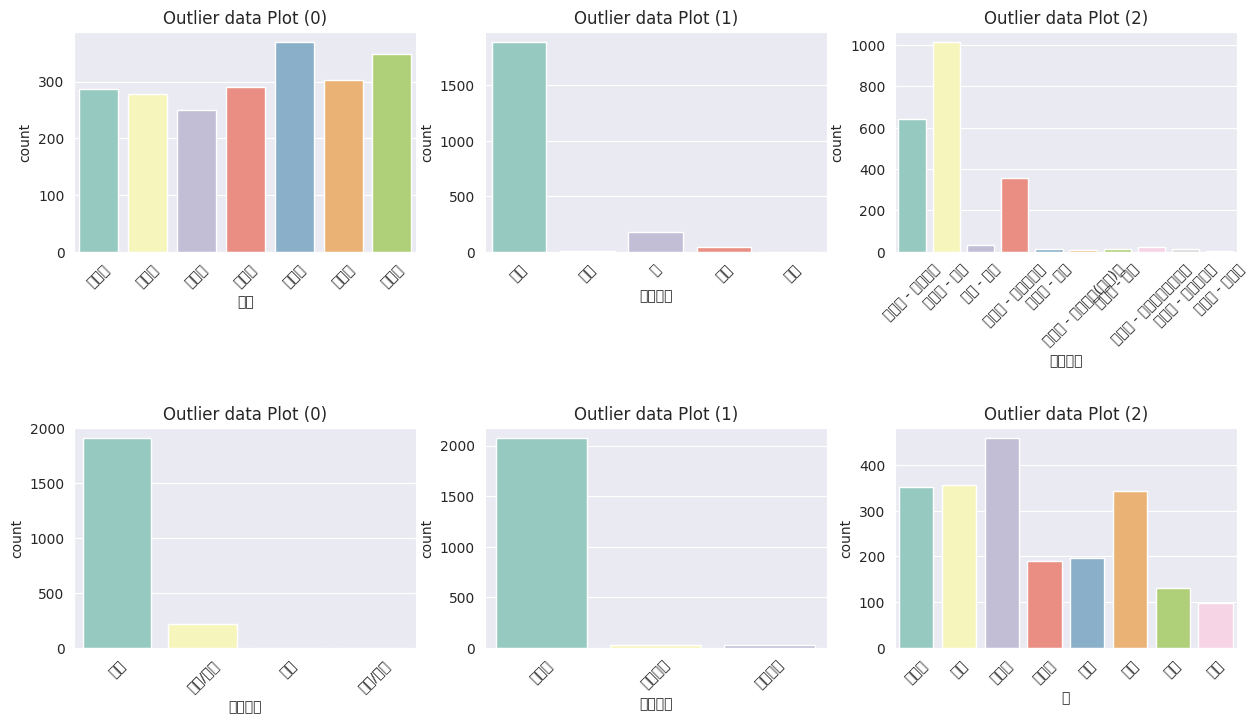

In [46]:
cols = ['요일' , '기상상태' , '도로형태' , '노면상태' , '사고유형' , '군']

fig , ax = plt.subplots(2 , 3 , figsize = (15 , 8))
plt.subplots_adjust(hspace = 0.8)

for i in range(6):
    row = i // 3
    col = i % 3

    sns.countplot(
        data = outlier_data ,
        x = cols[i] ,
        ax = ax[row][col]
    )

    ax[row][col].set_xticklabels(ax[row][col].get_xticklabels() , rotation = 45)
    ax[row][col].set_title(f"Outlier data Plot ({col})")

In [47]:
# 도로형태 추가 분석

train['도로형태(대분류)'] = train['도로형태'].str.split().str[0]

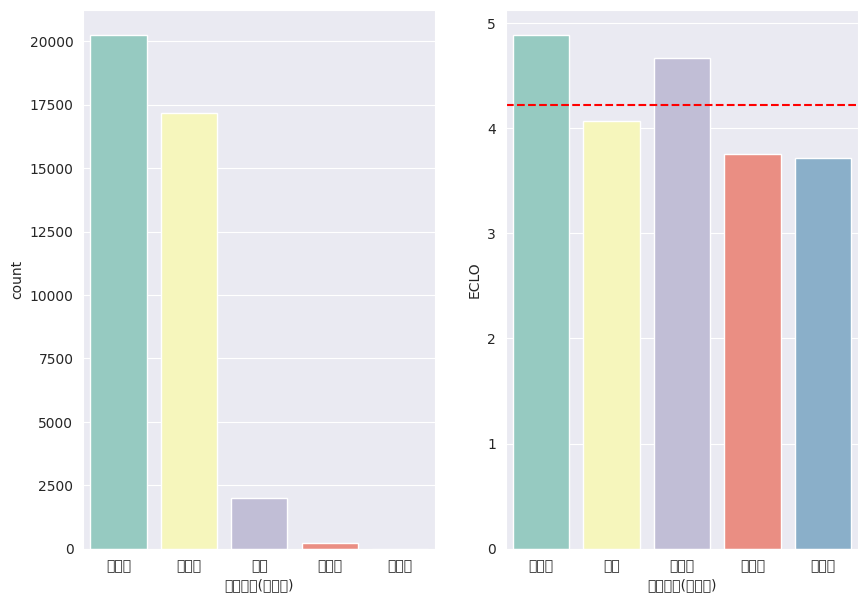

In [48]:
# 새로운 컬럼 "도로형태(대분류)" 시각화

fig , ax = plt.subplots(1 , 2 , figsize = (10 , 7))

sns.countplot(
    data = train ,
    x = "도로형태(대분류)" ,
    ax = ax[0]
)

data = train.groupby(['도로형태(대분류)']).agg({"ECLO" : "mean"})

sns.barplot(
    data = data ,
    x = data.index ,
    y = "ECLO" ,
    ax = ax[1]
)

ax[1].axhline(data['ECLO'].mean() , color = 'r' , linestyle = '--')

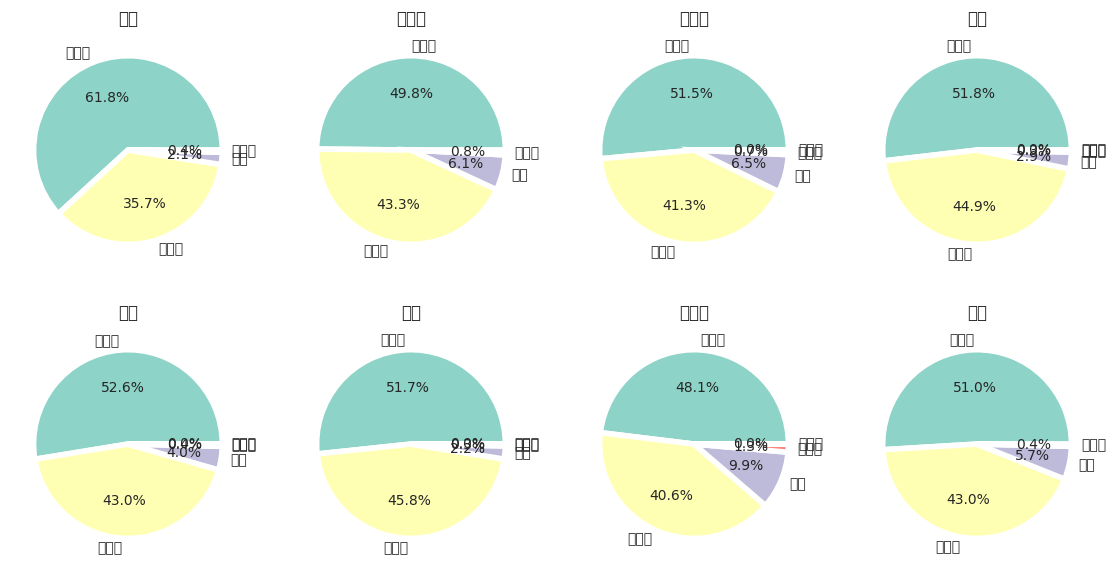

In [49]:
# 각 구별로 어느정도 비율로 분포해 있나?

fig , ax = plt.subplots(2 , 4 , figsize = (14 , 7))

for i in range(8):
    row = i // 4
    col = i % 4

    data = train[train['군'] == train['군'].unique()[i]]
    data = data.sort_values(by = "도로형태(대분류)" )

    ax[row][col].pie(data['도로형태(대분류)'].value_counts() / len(data) , labels = data['도로형태(대분류)'].value_counts().index ,
            autopct = '%1.1f%%' , wedgeprops = {"linewidth" : 4})

    ax[row][col].set_title(f"{train['군'].unique()[i]}")

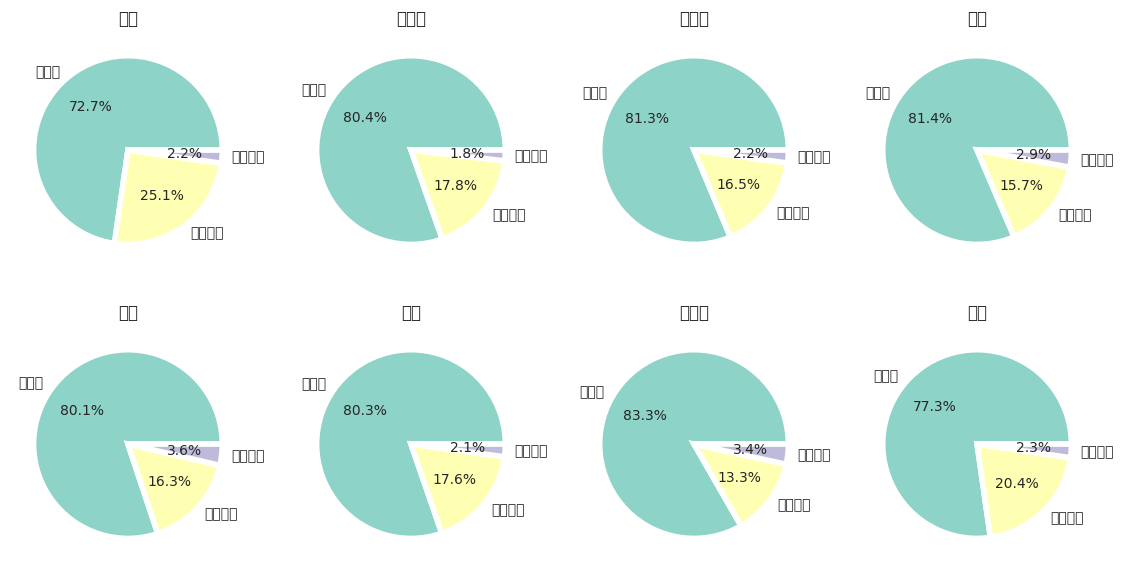

In [50]:
fig , ax = plt.subplots(2 , 4 , figsize = (14 , 7))

for i in range(8):
    row = i // 4
    col = i % 4

    data = train[train['군'] == train['군'].unique()[i]]
    data = data.sort_values(by = "사고유형" )

    ax[row][col].pie(data['사고유형'].value_counts() / len(data) , labels = data['사고유형'].value_counts().index ,
            autopct = '%1.1f%%' , wedgeprops = {"linewidth" : 4})

    ax[row][col].set_title(f"{train['군'].unique()[i]}")

<Axes: xlabel='요일', ylabel='count'>

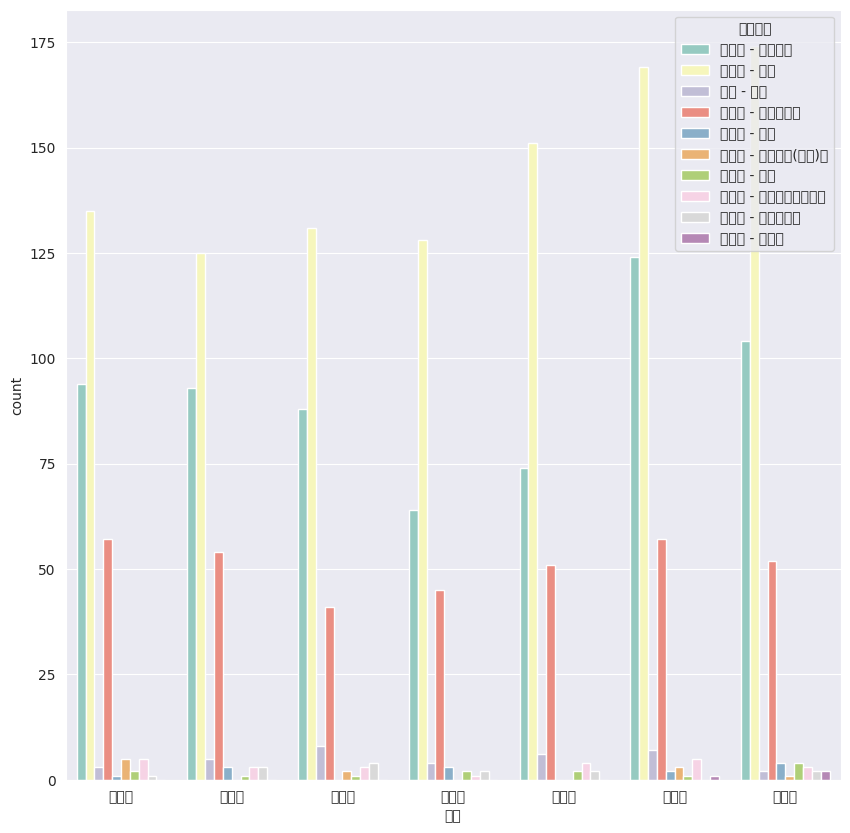

In [51]:
plt.figure(figsize = (10 , 10))

sns.countplot(
    data = outlier_data ,
    x = '요일' ,
    hue = '도로형태' ,
    order = ['월요일' , '화요일' , '수요일' , '목요일' , '금요일' , '토요일' , '일요일']
)

In [52]:
data = outlier_data.groupby(['요일'])['도로형태'].value_counts()

for idx in ['월요일' , '화요일' , '수요일' , '목요일' , '금요일' , '토요일' , '일요일']:
    print(f"{idx} : {data[idx]['교차로 - 교차로안'] / sum(data[idx]) * 100}")

월요일 : 31.02310231023102
화요일 : 32.40418118466899
수요일 : 31.654676258992804
목요일 : 25.702811244979916
금요일 : 25.517241379310345
토요일 : 33.60433604336043
일요일 : 29.88505747126437


#### 데이터 추가

In [53]:
cctv = pd.read_csv(path + "/CCTV.csv" , encoding = 'cp949')

cctv.head(3)

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013


In [54]:
# 필요없는 컬럼 drop

cctv.drop(['무인교통단속카메라관리번호' , '도로노선번호' , '도로노선명' , '도로노선방향' , '위도' , '경도' , '단속구분' ,
           '소재지도로명주소' , '설치장소' , '단속구간위치구분' , '과속단속구간길이' , '보호구역구분'] , axis = 1 , inplace = True)

In [55]:
# 데이터 타입 변경

cctv = cctv.astype({"설치연도" : "int"})

<Axes: >

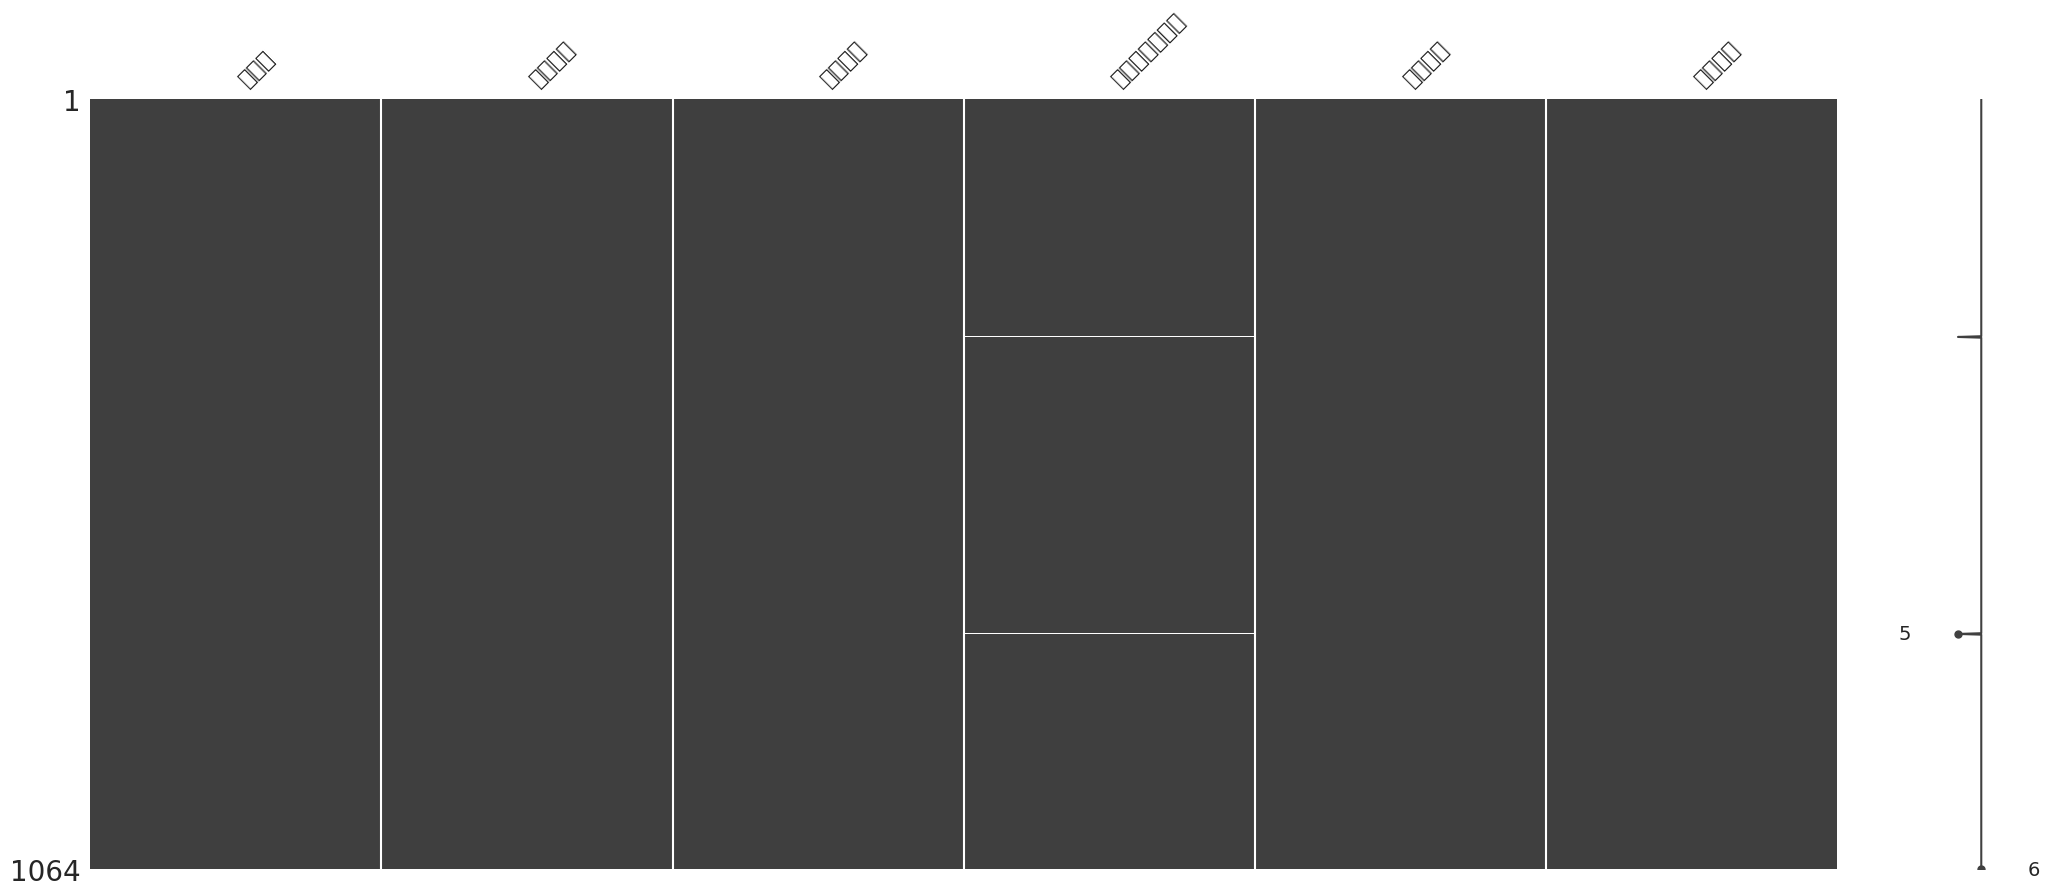

In [56]:
msno.matrix(cctv)

In [57]:
# 2019 ~ 2021년 데이터 가져오기

cctv = cctv[(cctv['설치연도'] >= 2019) & (cctv['설치연도'] <= 2021)]
cctv.head(4)

,시도명,시군구명,도로종류,소재지지번주소,제한속도,설치연도
24,대구광역시,남구,시도,대구광역시 남구 대명동 332-2,0,2019
25,대구광역시,남구,시도,대구광역시 남구 대명동 2296-29,0,2019
26,대구광역시,남구,시도,대구광역시 남구 이천동 655-144,0,2019
27,대구광역시,남구,시도,대구광역시 남구 대명동 960,0,2019


In [58]:
# 우리가 대상으로 잡은 8개의 구역에 들어가 있어야 하기에 , 필터링

cctv = cctv[cctv['시군구명'].isin(['남구' , '북구' , '서구' , '동구' , '중구' , '달성군' , '수성구' , '달서구'])]
cctv.shape

(481, 6)

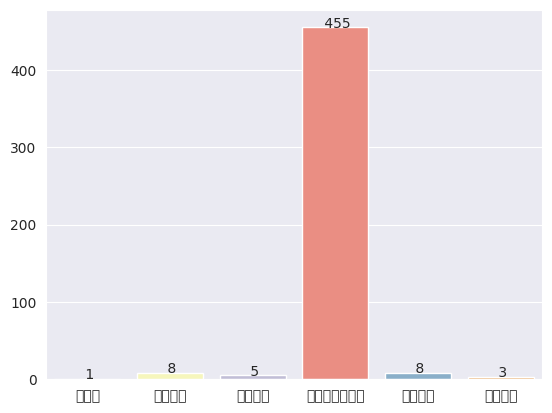

In [59]:
# cardinality

g = sns.barplot(
    x = cctv.nunique().index ,
    y = cctv.nunique().values
)

for p in g.patches:
    g.text(
        p.get_x() + (p.get_width() / 2) ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : 0.0f}" ,
        ha = "center"
    )

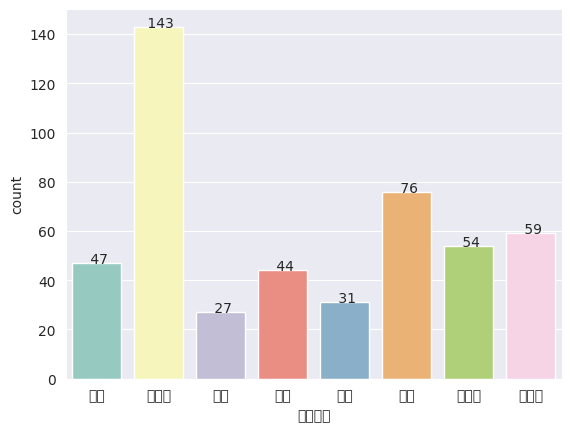

In [60]:
# 시군구 별로 설치된 cctv 개수

g = sns.countplot(
    x = cctv['시군구명'] ,
    order = cctv['시군구명'].unique()
)

for p in g.patches:
    g.text(
        p.get_x() + (p.get_width() / 2) ,
        p.get_y() + p.get_height() ,
        f"{p.get_height() : 0.0f}" ,
        ha = "center"
    )

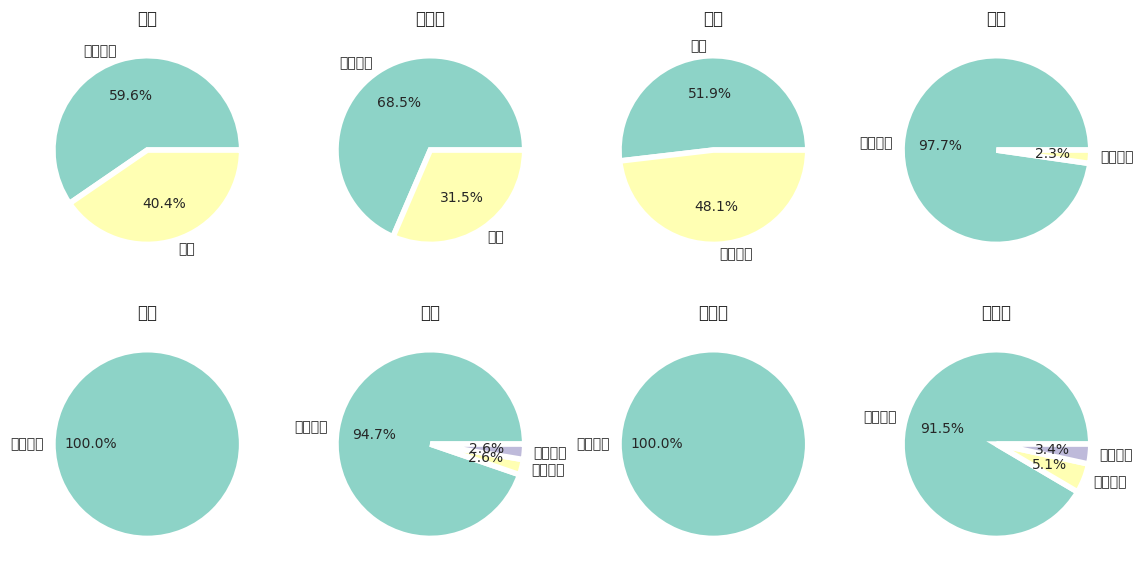

In [61]:
# 시군구별 도로종류 비율

fig , ax = plt.subplots(2 , 4 , figsize = (14 , 7))

for i in range(8):
    row = i // 4
    col = i % 4

    data = cctv[cctv['시군구명'] == cctv['시군구명'].unique()[i]]
    data = data.sort_values(by = "도로종류")

    ax[row][col].pie(data['도로종류'].value_counts() / len(data) , labels = data['도로종류'].value_counts().index ,
            autopct = '%1.1f%%' , wedgeprops = {"linewidth" : 4})

    ax[row][col].set_title(f"{cctv['시군구명'].unique()[i]}")

<Axes: xlabel='도로종류'>

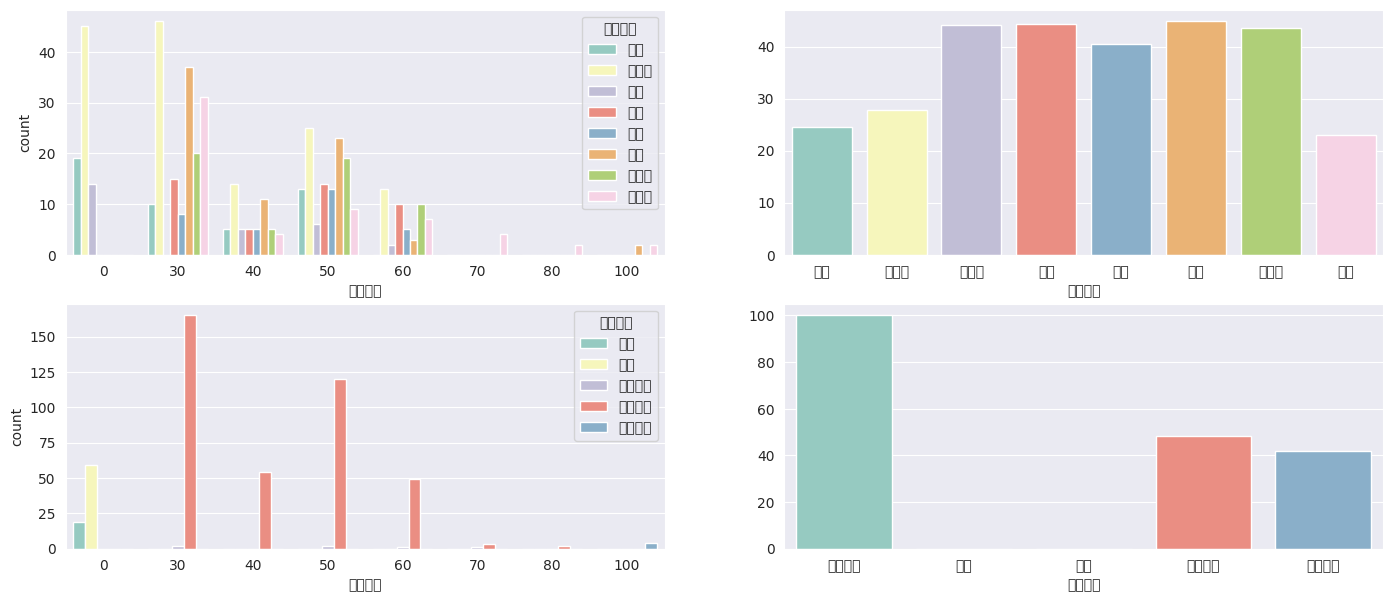

In [62]:
# 제한속도

fig , ax = plt.subplots(2 , 2 , figsize = (17 , 7))

sns.countplot(
    x = cctv['제한속도'] ,
    hue = cctv['시군구명'] ,
    ax = ax[0][0]
)

data = cctv.groupby(['시군구명'])['제한속도'].mean()

sns.barplot(
    x = data.index ,
    y = data.values ,
    ax = ax[0][1]
)

sns.countplot(
    x = cctv['제한속도'] ,
    hue = cctv['도로종류'] ,
    ax = ax[1][0]
)

data = cctv.groupby(['도로종류'])['제한속도'].mean()

sns.barplot(
    x = data.index ,
    y = data.values ,
    ax = ax[1][1]
)

##### 데이터 병합

In [63]:
# 이상치 처리

# 상한 대체
def replace_outlier(train , col):
    q1 = np.percentile(train[col] , 25)
    q3 = np.percentile(train[col] , 75)
    IQR = q3 - q1
    lower_fecne = q1 - 1.5 * IQR
    upper_fence = q3 + 1.5 * IQR

    return train[col].apply(lambda x : train[col].mode().iloc[0] if x < lower_fence or x > upper_fence else x)

train['ECLO'] = replace_outlier(train , 'ECLO')

In [64]:
cctv = cctv.dropna()

In [65]:
data = list(cctv['소재지지번주소'].str.split().str[0:3])

detail = []
for i in range(len(data)):
    detail.append(" ".join(data[i]))

In [66]:
cctv['시군구'] = detail

In [67]:
print(f"CCTV 시군구 데이터 : {len(cctv['시군구'].unique())}")
print(f"TRAIN 시군구 데이터 : {len(train['시군구'].unique())}")
print(f"차이 : {len(train['시군구'].unique()) - len(cctv['시군구'].unique())}")

CCTV 시군구 데이터 : 116
TRAIN 시군구 데이터 : 199
차이 : 83


In [68]:
merged_data = pd.merge(train , cctv , on = '시군구' , how = 'left')

In [69]:
# NA 값 비율

for col in merged_data.columns:
    print(f"{col} NA Percentage : {merged_data[col].isna().sum() / len(merged_data) * 100}%")

ID NA Percentage : 0.0%
사고일시 NA Percentage : 0.0%
요일 NA Percentage : 0.0%
기상상태 NA Percentage : 0.0%
시군구 NA Percentage : 0.0%
도로형태 NA Percentage : 0.0%
노면상태 NA Percentage : 0.0%
사고유형 NA Percentage : 0.0%
군 NA Percentage : 0.0%
구 NA Percentage : 0.0%
ECLO NA Percentage : 0.0%
도로형태(대분류) NA Percentage : 0.0%
시도명 NA Percentage : 1.7542639970337413%
시군구명 NA Percentage : 1.7542639970337413%
도로종류 NA Percentage : 1.7542639970337413%
소재지지번주소 NA Percentage : 1.7542639970337413%
제한속도 NA Percentage : 1.7542639970337413%
설치연도 NA Percentage : 1.7542639970337413%


In [70]:
print(f"NA 처리 전 데이터 길이 : {len(merged_data)}")
print(f"NA 처리 후 데이터 길이 : {len(merged_data.dropna())}")

NA 처리 전 데이터 길이 : 258912
NA 처리 후 데이터 길이 : 254370


In [71]:
duplicated_rows = merged_data[merged_data.duplicated()]

In [72]:
merged_data = merged_data.drop_duplicates()

In [73]:
merged_data_temp = merged_data.copy()

## 군집 분석

### 전처리

In [74]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254458 entries, 0 to 258911
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ID         254458 non-null  object        
 1   사고일시       254458 non-null  datetime64[ns]
 2   요일         254458 non-null  object        
 3   기상상태       254458 non-null  object        
 4   시군구        254458 non-null  object        
 5   도로형태       254458 non-null  object        
 6   노면상태       254458 non-null  object        
 7   사고유형       254458 non-null  object        
 8   군          254458 non-null  object        
 9   구          254458 non-null  object        
 10  ECLO       254458 non-null  int64         
 11  도로형태(대분류)  254458 non-null  object        
 12  시도명        249916 non-null  object        
 13  시군구명       249916 non-null  object        
 14  도로종류       249916 non-null  object        
 15  소재지지번주소    249916 non-null  object        
 16  제한속도       249916 no

In [75]:
target = merged_data["ECLO"]

merged_data.drop(["ID" , "사고일시" , "기상상태" , "구" , "도로형태(대분류)" , "시도명" ,
                  "시군구명" , "소재지지번주소"] , axis = 1 , inplace = True)

In [76]:
merged_data_temp = merged_data.copy()

### Encoding

In [77]:
# category_encoders 설치

!pip install category_encoders

In [78]:
from category_encoders.target_encoder import TargetEncoder

categorical_features = ['요일' , '도로형태', '노면상태', '사고유형', '군', '도로종류', '제한속도']

for feature in categorical_features:
    TR = TargetEncoder(cols = [feature])
    merged_data[feature] = TR.fit_transform(merged_data[feature] , target)

In [79]:
merged_data['구'] = merged_data['시군구'].str.split().str[1]

In [80]:
merged_data.drop(['시군구'] , axis = 1 , inplace = True)

merged_data_group = merged_data.groupby(['구'])['요일' , '도로형태' , '노면상태' ,
                                                 '사고유형' , '군' , '도로종류' , '제한속도'].mean()

In [81]:
merged_data_group.drop(['군'] , axis = 1 , inplace = True)

In [82]:
# 엘보우 메소드 , 실루엣 방법

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def elbow(df):
    sse = []
    for i in range(1 , len(df)):
        km = KMeans(n_clusters = i)
        km.fit(df)
        sse.append(km.inertia_)
    sns.lineplot(
        x = range(1 , len(df)) ,
        y = sse ,
        marker = 'o' ,
        color = 'g'
    )
    plt.title("Elbow Method")
    plt.xlabel("number of cluster")
    plt.ylabel("sum of square error")

def silhouette(df):
    silhouette = []
    for i in range(2 , len(df)):
        km = KMeans(n_clusters = i)
        km.fit(df)
        score = silhouette_score(df , km.labels_)
        silhouette.append(score)

    sns.lineplot(
        x = range(2 , len(df)) ,
        y = silhouette ,
        marker = 'o' ,
        color = 'g'
    )
    plt.title("Silhouette Method")
    plt.xlabel("number of cluster")
    plt.ylabel("Score")

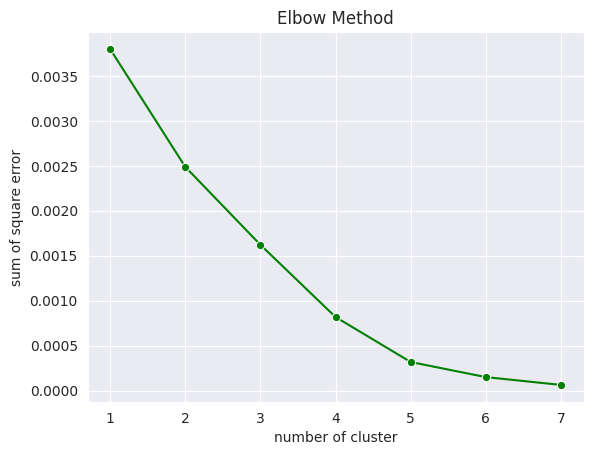

In [83]:
elbow(merged_data_group)

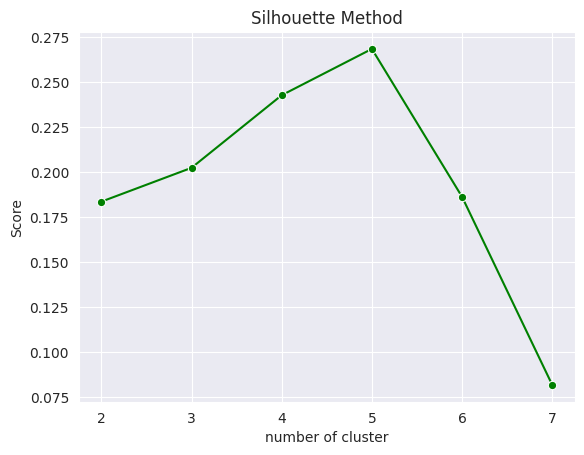

In [84]:
silhouette(merged_data_group)

In [85]:
"""
K = 3 or K = 4가 적절한 것 같다
"""

km = KMeans(n_clusters = 4)
km.fit(merged_data_group)

merged_data_group['Cluster'] = km.predict(merged_data_group)

Text(0.5, 1.0, 'PCA K-means')

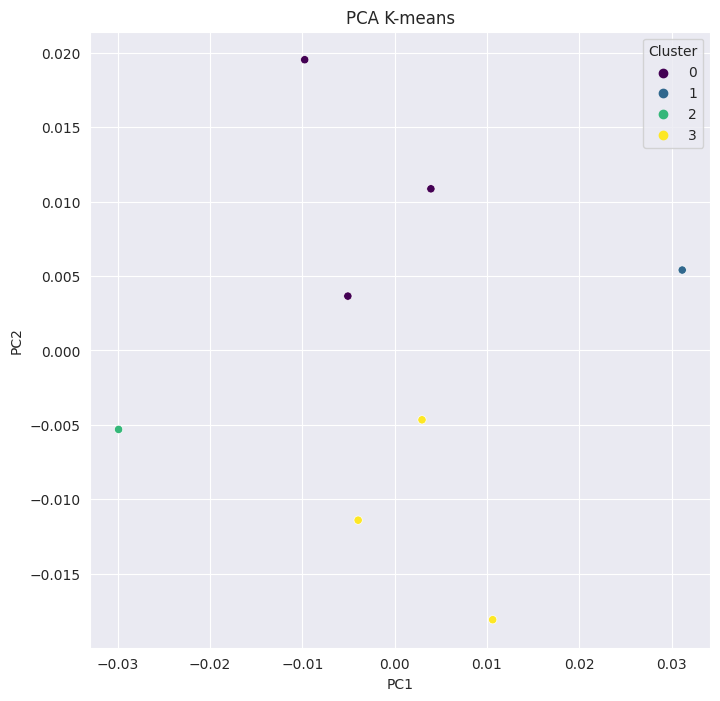

In [86]:
from sklearn.decomposition import PCA

plt.figure(figsize = (8 , 8))

pca = PCA(n_components = 2)
data_pca = pca.fit_transform(merged_data_group.drop(['Cluster'] , axis = 1))

data_pca = pd.DataFrame(data_pca , columns = ['PC1' , 'PC2'])
data_pca['Cluster'] = list(merged_data_group['Cluster'])

sns.scatterplot(x = 'PC1' ,
                y = 'PC2' ,
                hue = 'Cluster' ,
                data = data_pca ,
                palette = 'viridis')
plt.title("PCA K-means")

In [87]:
merged_data = pd.merge(merged_data , merged_data_group['Cluster'] , on = '구' , how = 'left')

In [88]:
merged_data.drop(['군' , '구'] , axis = 1 , inplace = True)

In [89]:
merged_data['설치연도'] = merged_data['설치연도'].fillna(2021.0)

In [90]:
merged_data_temp = merged_data_temp.rename(columns = {'군' : '구'})
merged_data_temp = pd.merge(merged_data_temp , merged_data_group['Cluster'] , on = '구' , how = 'left')

In [91]:
merged_data_temp = merged_data_temp.dropna()

In [92]:
merged_data_temp.drop(['시군구' , '구'] , axis = 1 , inplace = True)

categorical_features = ['요일' , '도로형태', '노면상태', '사고유형', '도로종류', '제한속도']
target = merged_data_temp['Cluster']

for feature in categorical_features:
    TR = TargetEncoder(cols = [feature])
    merged_data_temp[feature] = TR.fit_transform(merged_data_temp[feature] , target)

In [94]:
merged_data_temp

,요일,도로형태,노면상태,사고유형,ECLO,도로종류,제한속도,설치연도,Cluster
0,1.315770,1.295427,1.318752,1.324666,5,0.000000,0.929730,2021.0,0
1,1.315770,1.295427,1.318752,1.324666,5,1.411109,1.463223,2021.0,0
2,1.315770,1.295427,1.318752,1.324666,3,0.000000,0.929730,2021.0,0
3,1.315770,1.295427,1.318752,1.324666,3,1.411109,0.982284,2019.0,0
4,1.315770,1.295427,1.318752,1.324666,3,1.411109,1.269120,2020.0,0
...,...,...,...,...,...,...,...,...,...
254453,1.337159,2.186316,1.318752,1.320009,6,1.411109,1.700744,2021.0,3
254454,1.337159,2.186316,1.318752,1.320009,6,1.411109,1.700744,2021.0,3
254455,1.337159,2.186316,1.318752,1.320009,6,1.411109,1.700744,2021.0,3
254456,1.337159,2.186316,1.318752,1.320009,6,1.411109,1.700744,2021.0,3


### fitting & prediction

In [95]:
# 종속변수 재설정

target = merged_data_temp['Cluster']
merged_data_temp.drop(['Cluster'] , axis = 1 , inplace = True)

<Axes: xlabel='Cluster', ylabel='count'>

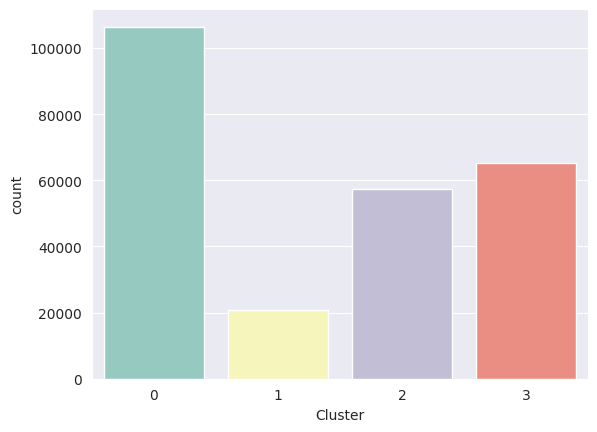

In [96]:
# Target 분포

sns.countplot(
    x = target
)

In [97]:
# 불균형 데이터 처리

from imblearn.over_sampling import SMOTE

smote = SMOTE()
smote_df , smote_target = smote.fit_resample(merged_data_temp , target)

<Axes: xlabel='Cluster', ylabel='count'>

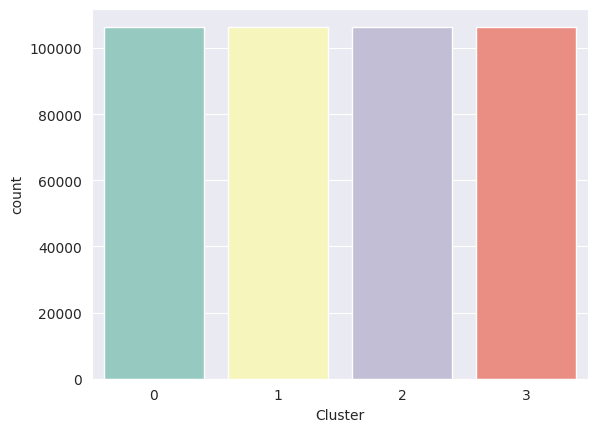

In [98]:
# 재확인

sns.countplot(
    x = smote_target
)

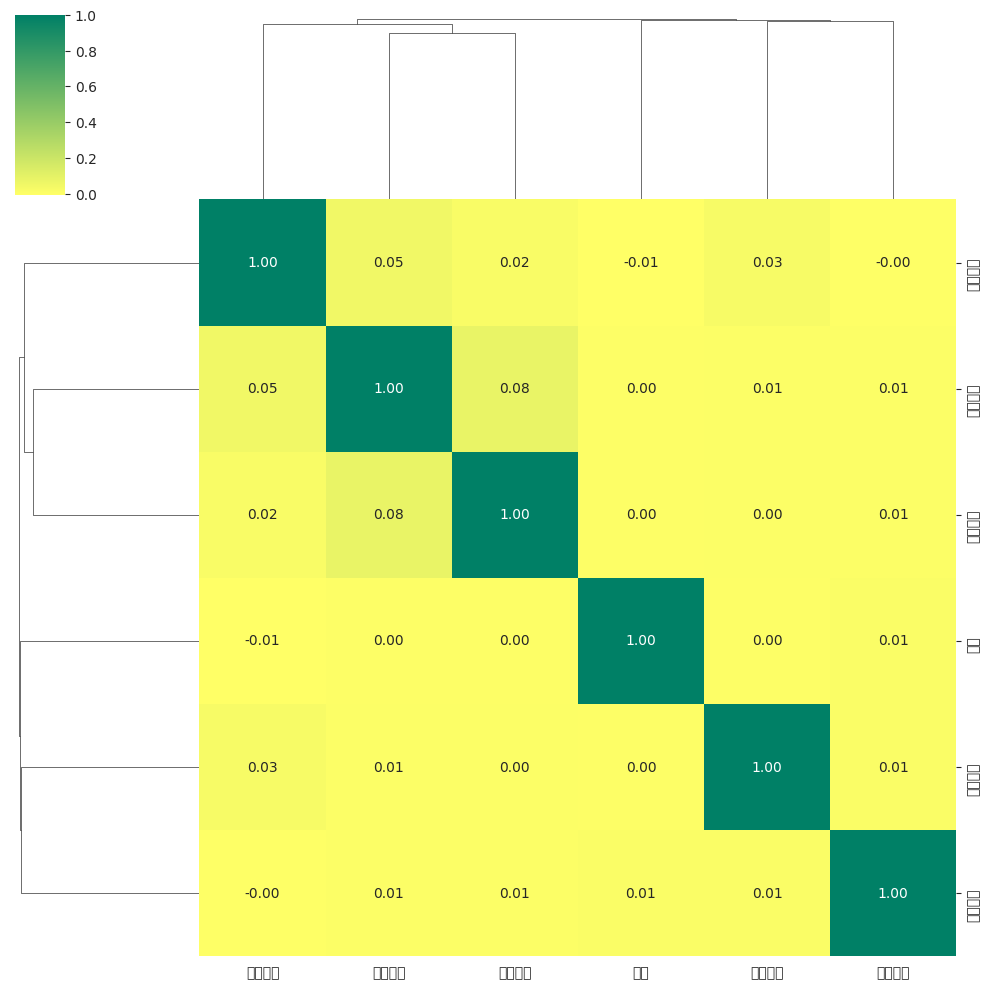

In [99]:
sns.clustermap(
    smote_df[['요일' , '도로형태' , '노면상태' , '사고유형' , '도로종류' , '제한속도']].corr() ,
    annot = True,
    fmt = '.2f' ,
    cmap = 'summer_r'
)

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

trainX , validX , trainY , validY = train_test_split(smote_df , smote_target , test_size = 0.2 , random_state = 42)

rf_model = RandomForestClassifier()

In [101]:
rf_model.fit(trainX , trainY)

RandomForestClassifier()

In [102]:
from sklearn import metrics

prediction = rf_model.predict(validX)
print(metrics.classification_report(validY , prediction))

              precision    recall  f1-score   support

           0       0.67      0.41      0.51     21298
           1       0.58      0.80      0.68     21179
           2       0.69      0.68      0.68     21223
           3       0.49      0.52      0.51     21473

    accuracy                           0.60     85173
   macro avg       0.61      0.60      0.59     85173
weighted avg       0.61      0.60      0.59     85173



In [103]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=d21efef3a298345914e0041c0fe18bf362e30d2d5eeb780dd1c0a16700a3250d
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [104]:
import eli5

from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

permutation = PermutationImportance(rf_model , scoring = 'r2' , random_state = 42).fit(validX , validY)
eli5.show_weights(permutation , feature_names = validX.columns.tolist())

Weight,Feature
0.2995 ± 0.0103,제한속도
0.2857 ± 0.0077,도로종류
0.1838 ± 0.0123,도로형태
0.1550 ± 0.0035,ECLO
0.1442 ± 0.0081,요일
0.1145 ± 0.0018,사고유형
0.1006 ± 0.0037,설치연도
0.0558 ± 0.0024,노면상태
